# Geodesic boundary value problem with fixed start and end shape

This notebook demonstrates the computation of an optimal motion path (sub Riemannian geodesic) between two fixed start and end shapes in world coordinates.
For this we solve a constrained optimization of the path energy with horizontal motion constraints.

The path energy is given by
1. **Inner dissipation**: Bending and membrane (stretching) energy of the curves
2. **Outer dissipation**: Outer dissipation due to friction, the dissipation is **anisotropic** and controlled by an anisotropic tensor: $a \cdot I + b \cdot T \otimes T$
    - $a$ controls isotropic dissipation
    - $b$ controls anisotropic dissipation (typically negative to make tangential motion easier)
    - $T$ is the tangent vector to the curve

**Constraints**: 
 - horizontal constraints: We enforce that each shape transition satisfies horizontal   compatibility conditions (geometric motion contraints) (6 constraints per time step).

In [1]:
import os
import numpy as np
import time
from types import SimpleNamespace
import matplotlib.pyplot as plt
from pathlib import Path

from constraints import *
from energies import *
from utils import * 

# # Get current working directory
working_dir = Path(os.getcwd())

### Define Optimization Parameters

- **K**: Number of time steps in the path (including start and end)
- **bending_weight**: Weight for bending energy (penalizes curvature)
- **membrane_weight**: Weight for membrane energy (penalizes stretching)
- **a_weight**: Isotropic dissipation coefficient
- **b_weight**: Anisotropic dissipation coefficient (negative allows easier tangential motion)

In [2]:
# Time steps of path
K = 15
num_freeShapes = K - 1  # First and last shapes are fixed

# Specify parameters
param = {
    'bending_weight': 0.001,      # Controls resistance to bending
    'membrane_weight': 1.0,        # Controls resistance to stretching
    'energy_weight': 10.0,          # energy weight for outer dissipation
    'a_weight': 1.0,               # Isotropic dissipation
    'b_weight': -0.95,             # Anisotropic dissipation (negative = easier tangential motion)
    'K': K,
    'mass_factor': None             #allows to set vertex-wise mass, if None, it is set to 1 for all vertices
}

parameters = SimpleNamespace(**param)

print("Optimization Parameters:")
for key, value in param.items():
    print(f"  {key}: {value}")

Optimization Parameters:
  bending_weight: 0.001
  membrane_weight: 1.0
  energy_weight: 10.0
  a_weight: 1.0
  b_weight: -0.95
  K: 15
  mass_factor: None


In [3]:
# Define path to data
# Adjust this path based on your repository structure
data_path = working_dir.parent.parent / "data" /"BVP"

# Load start shape
xA, lines = read_obj_curve(data_path / 'startbvp.obj')
xB, _ = read_obj_curve(data_path / 'endbvp.obj')

print(f"Start shape has {len(xA)} vertices")
print(f"Shape dimensions: {xA.shape}")

# Specify the plane of the 2D curves (xy-plane)
normals = np.array([0., 0., 1.])

Start shape has 15 vertices
Shape dimensions: (15, 3)


### Visualize Start and End Shapes

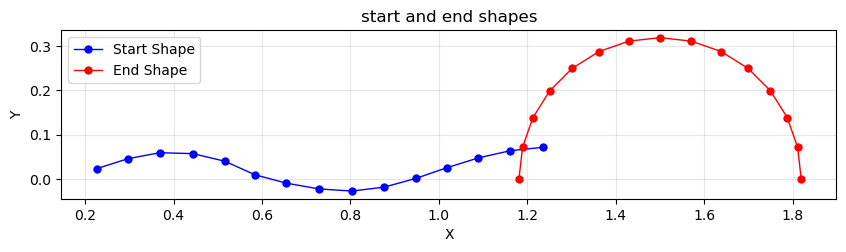

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(xA[:, 0], xA[:, 1], 'o-', linewidth=1, markersize=5, label='Start Shape', color='blue')
ax.plot(xB[:, 0], xB[:, 1], 'o-', linewidth=1, markersize=5, label='End Shape', color='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('start and end shapes')
ax.set_aspect('equal', 'box')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

We start with a simple "jumping" initialization where the first half of the path stays at shape A and the second half jumps to shape B.

In [5]:
# Reshape to correct format (flatten in Fortran order)
xA = xA.reshape(-1, order='F') 
xB = xB.reshape(-1, order='F')
xA = np.reshape(xA, (1, -1))
xB = np.reshape(xB, (1, -1))

print(f"xA shape: {xA.shape}")
print(f"xB shape: {xB.shape}")

# Initialize with constant path (jumping in the middle)
x0 = np.concatenate([int((K-1)/2) * [xA], int((K-1)/2) * [xB]])
x0 = x0.reshape(-1)

print(f"Initial path shape: {x0.shape}")
print(f"Total degrees of freedom: {len(x0)}")

xA shape: (1, 45)
xB shape: (1, 45)
Initial path shape: (630,)
Total degrees of freedom: 630


Set up the arguments and constraints for the optimization.

In [6]:
# Define parameters for energy functions
args = (
    lines, normals,
    parameters.bending_weight,
    parameters.membrane_weight,
    K, xA, xB,
    parameters.energy_weight,
    parameters.a_weight,
    parameters.b_weight,
    parameters.mass_factor
)

# Define horizontal constraint (6 constraints per time step)
constr_horizontal = create_horizontal_constraint(
    K, xA, xB,
    parameters.a_weight,
    parameters.b_weight,
    parameters.mass_factor
)

### Unconstrained Optimization
We first minimize the path energy without constraints using Newton-CG. This gives us a good starting point for the constrained optimization.

In [7]:
print("Starting unconstrained optimization...")
print("Method: Newton-CG")
print("="*60)

start_time = time.time()

optResult = scipy.optimize.minimize(
    path_energy.pathEnergy,
    x0,
    args,
    jac=path_energy.gradientPathEnergy,
    hess=path_energy.hessianPathEnergy,
    method='Newton-CG',
    options={'maxiter': 1000, 'disp': True}
)

unconstrained_time = time.time() - start_time

print(f"\nUnconstrained optimization completed in {unconstrained_time:.2f} seconds")
print(f"Success: {optResult.success}")
print(f"Final energy: {optResult.fun:.6f}")
print(f"Iterations: {optResult.nit}")

# Use result as starting point for constrained optimization
x0 = optResult.get('x')

Starting unconstrained optimization...
Method: Newton-CG
Optimization terminated successfully.
         Current function value: 0.463957
         Iterations: 76
         Function evaluations: 117
         Gradient evaluations: 117
         Hessian evaluations: 76

Unconstrained optimization completed in 8.80 seconds
Success: True
Final energy: 0.463957
Iterations: 76


We visualize the result. This is a pure energy minimizationm, so no geometric motion path.

In [8]:
# Reshape and add fixed start/end shapes
pos = np.reshape(x0, (num_freeShapes, -1)) 
pos = np.concatenate((xA, pos, xB))

# Reshape to 3D coordinates
path = pos.reshape((pos.shape[0], -1, 3), order='F')
#visualize the paths, this is a pure energy minimization so no motion path
animate_shape_sequence(path, save=False, returnHTML=True)

### Constrained Optimization
We minimize the path energy with horizontal constraints using trust-constr algorithm. The minimization will take around 100 seconds.

In [9]:
print("\nStarting constrained optimization...")
print("Method: trust-constr")
print("="*60)

start_time = time.time()

optResult = scipy.optimize.minimize(
    path_energy.pathEnergy,
    x0,
    args,
    jac=path_energy.gradientPathEnergy,
    hess=path_energy.hessianPathEnergy,
    method='trust-constr',
    options={'maxiter': 3000, 'disp': True},
    constraints={constr_horizontal}
)

constrained_time = time.time() - start_time

print(f"\nConstrained optimization completed in {constrained_time:.2f} seconds")
print(f"Success: {optResult.success}")
print(f"Final energy: {optResult.fun:.6f}")
print(f"Iterations: {optResult.nit}")

# Get optimized path
opt = optResult.get('x')

# Reshape and add fixed start/end shapes
pos = np.reshape(opt, (num_freeShapes, -1)) 
pos = np.concatenate((xA, pos, xB))

# Reshape to 3D coordinates
path = pos.reshape((pos.shape[0], -1, 3), order='F')

print(f"Path shape: {path.shape}")
print(f"Number of time steps: {len(path)}")
print(f"Vertices per shape: {path.shape[1]}")


Starting constrained optimization...
Method: trust-constr
`xtol` termination condition is satisfied.
Number of iterations: 690, function evaluations: 990, CG iterations: 71662, optimality: 1.25e-06, constraint violation: 3.88e-17, execution time: 9.8e+01 s.

Constrained optimization completed in 102.27 seconds
Success: True
Final energy: 1.017736
Iterations: 690
Path shape: (16, 15, 3)
Number of time steps: 16
Vertices per shape: 15


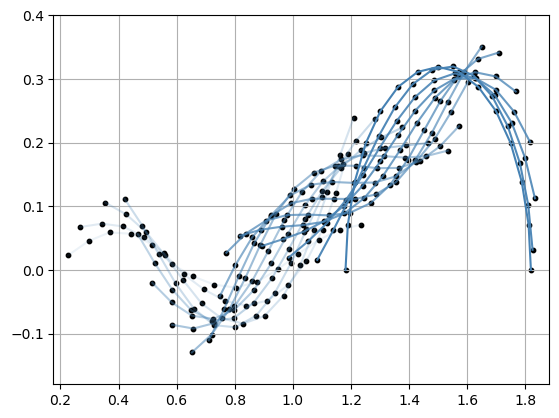

In [10]:
visualize_shape_sequence(path, save=False)

In [11]:
animate_shape_sequence(path, save=False, returnHTML=True)